In [46]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, Conv2D

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import ADASYN
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Reshape
from imblearn.over_sampling import SMOTE
from keras.layers import LSTM


In [47]:
malta_loc_18 = '../data/Malta-Budget-2018-dataset-v1.csv'
malta_loc_19 = '../data/Malta-Budget-2019-dataset-v1.csv'
malta_loc_20 = '../data/Malta-Budget-2020-dataset-v1.csv'

malta_data_18 = pd.read_csv(malta_loc_18)
malta_data_19 = pd.read_csv(malta_loc_19)
malta_data_20 = pd.read_csv(malta_loc_20)

print(malta_data_18.info())
print(malta_data_19.info())
print(malta_data_20.info())

malta_data_19 = malta_data_19.rename(columns={'Off-topic ':'Off-topic'})
combined_data = pd.concat([malta_data_18, malta_data_19, malta_data_20], ignore_index=True)
combined_data.info()

clean_data = combined_data.dropna(subset=['Online Post Text'])
clean_data = clean_data.drop(['Twitter ID', 'Related Online Post ID', 'Source ID','Off-topic'], axis=1)
clean_data = clean_data[clean_data['Language'] == 0] # get all data that is in english 
clean_data = clean_data.drop(['Language'], axis=1)
clean_data = clean_data.rename(columns={'Online Post ID':'ID','Online Post Text':'Text'})
clean_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Online Post ID          2142 non-null   int64  
 1   Twitter ID              1673 non-null   float64
 2   Related Online Post ID  333 non-null    float64
 3   Source ID               2142 non-null   object 
 4   Online Post Text        469 non-null    object 
 5   Subjectivity            2142 non-null   int64  
 6   Sentiment Polarity      2142 non-null   object 
 7   Emotion                 2142 non-null   object 
 8   Sarcasm                 2142 non-null   int64  
 9   Irony                   2142 non-null   int64  
 10  Negation                2142 non-null   int64  
 11  Off-topic               2142 non-null   int64  
 12  Language                2142 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 217.7+ KB
None
<class 'pandas.core.frame.Dat

,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation
0,20180001,Great BUDGET . Even cigarettes were not touche...,1,positive,trust,0,0,1
1,20180002,I haven't exactly scanned the budget throughou...,1,negative,disgust,0,0,1
2,20180003,There’s already smoking cessation programs for...,1,neutral,anticipation,0,0,0
3,20180004,So should alcohol and fuel for private vehicle...,1,negative,sadness,0,0,0
4,20180005,Practical? You should say that in a third worl...,1,negative,anger,0,0,1


In [48]:
import string
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
from transformers import BertTokenizer
from transformers import AutoTokenizer

processed_data = clean_data.copy(deep=True)

def remove_special_characters(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    return pattern.sub('', text)

# Remove URLs and HTML tags
processed_data['Text'] = processed_data['Text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
processed_data['Text'] = processed_data['Text'].str.replace(r'<.*?>', '', regex=True)

# Expand contractions
processed_data['Text'] = processed_data['Text'].apply(lambda x: contractions.fix(x))

# Convert to lowercase
processed_data['Text'] = processed_data['Text'].str.lower()

# Remove punctuation
processed_data['Text'] = processed_data['Text'].str.replace(f"[{string.punctuation}]", " ", regex=True)

# Remove numbers
processed_data['Text'] = processed_data['Text'].str.replace(r'\d+', '', regex=True)

# Remove special characters
processed_data['Text'] = processed_data['Text'].apply(remove_special_characters)

# Remove stop words
stop_words = set(stopwords.words('english'))
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Remove extra whitespace
processed_data['Text'] = processed_data['Text'].str.strip()
processed_data['Text'] = processed_data['Text'].str.replace(r'\s+', ' ', regex=True)

# Lemmatize
lemmatizer = WordNetLemmatizer()
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

# Tokenize
# tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment") #96574
# tokenizer_features = 110000
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #30522 
tokenizer_features = 30522
processed_data['tokens'] = processed_data['Text'].apply(lambda x: tokenizer.tokenize(x)) 

max_words = processed_data['Text'].apply(lambda x: len(x.split())).max()
print(f"The longest record is : {max_words} words")

max_tokens = processed_data['tokens'].apply(lambda x: len(x)).max()
print(f"The longest record is : {max_words} tokens")

def encode_texts(texts, tokenizer, max_len): 
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return input_ids, attention_masks

processed_data['padded'], processed_data['masks'] = encode_texts(processed_data['Text'].tolist(), tokenizer, 100)

# Encode
# processed_data['encoded'] = processed_data['tokens'].apply(lambda x: tokenizer.convert_tokens_to_ids(x))

processed_data.head()

[nltk_data] Downloading package wordnet to /Users/alex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The longest record is : 171 words
The longest record is : 171 tokens


,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation,tokens,padded,masks
0,20180001,great budget even cigarette touched great work...,1,positive,trust,0,0,1,"[great, budget, even, cigarette, touched, grea...","[101, 2307, 5166, 2130, 9907, 5028, 2307, 2147...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,20180002,exactly scanned budget throughout earth make i...,1,negative,disgust,0,0,1,"[exactly, scanned, budget, throughout, earth, ...","[101, 3599, 11728, 5166, 2802, 3011, 2191, 166...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,20180003,already smoking cessation program people want ...,1,neutral,anticipation,0,0,0,"[already, smoking, ce, ##ssa, ##tion, program,...","[101, 2525, 9422, 8292, 11488, 3508, 2565, 211...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,20180004,alcohol fuel private vehicle raising tax cigar...,1,negative,sadness,0,0,0,"[alcohol, fuel, private, vehicle, raising, tax...","[101, 6544, 4762, 2797, 4316, 6274, 4171, 9907...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,20180005,practical say third world country supposed eur...,1,negative,anger,0,0,1,"[practical, say, third, world, country, suppos...","[101, 6742, 2360, 2353, 2088, 2406, 4011, 2647...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


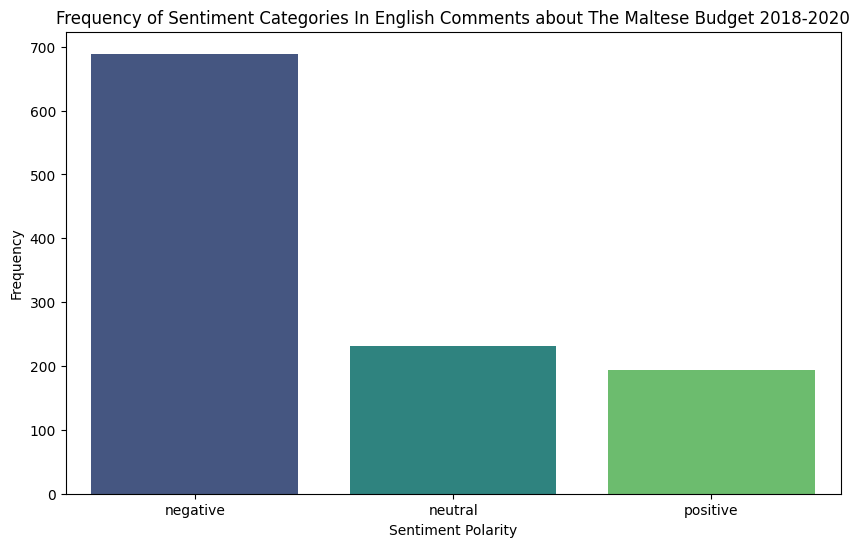

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

value_counts = processed_data['Sentiment Polarity'].value_counts()

# Plotting the frequency of string values in the 'Category' column
plt.figure(figsize=(10, 6))
sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis', hue=value_counts.index, legend=False)
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Frequency of Sentiment Categories In English Comments about The Maltese Budget 2018-2020')
plt.show()

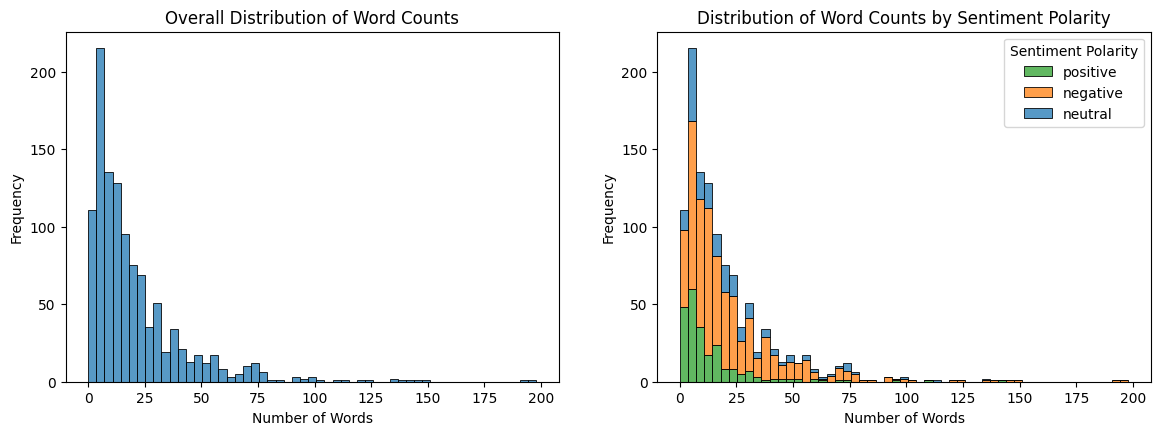

In [50]:
processed_data['num_words'] = processed_data['tokens'].apply(lambda x: len(x))

plt.figure(figsize=(14,10))

ax = plt.subplot(2,2,1)
sns.histplot(processed_data['num_words'], kde=False)
plt.title('Overall Distribution of Word Counts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
# plt.show()

ax = plt.subplot(2,2,2)
sns.histplot(processed_data, x='num_words', hue='Sentiment Polarity', multiple='stack', kde=False)
plt.title('Distribution of Word Counts by Sentiment Polarity')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend(title='Sentiment Polarity', labels = processed_data['Sentiment Polarity'])

In [51]:
processed_data = processed_data[processed_data['num_words'] <= 100]
processed_data["Sentiment Polarity"].value_counts()

Sentiment Polarity
negative    680
neutral     230
positive    191
Name: count, dtype: int64

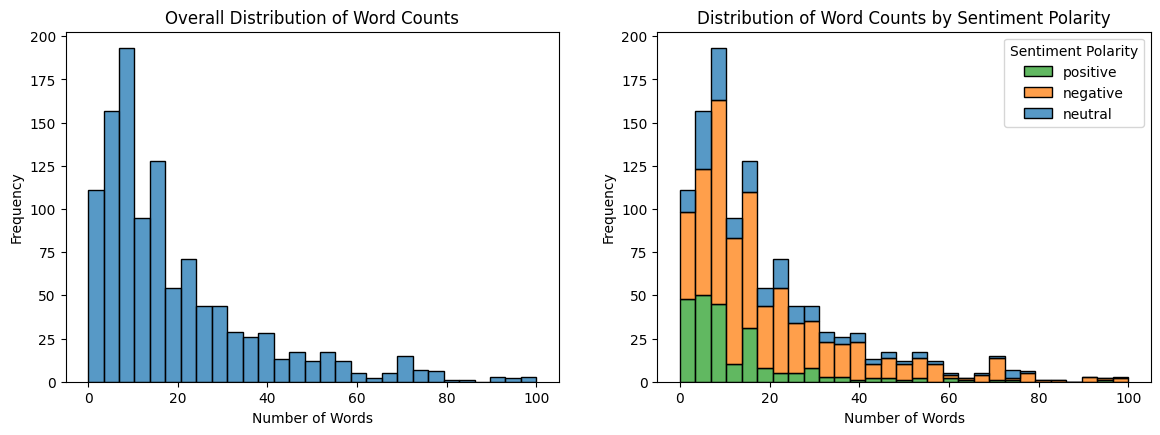

In [52]:
plt.figure(figsize=(14,10))

ax = plt.subplot(2,2,1)
sns.histplot(processed_data['num_words'], kde=False)
plt.title('Overall Distribution of Word Counts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
# plt.show()

ax = plt.subplot(2,2,2)
sns.histplot(processed_data, x='num_words', hue='Sentiment Polarity', multiple='stack', kde=False)
plt.title('Distribution of Word Counts by Sentiment Polarity')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend(title='Sentiment Polarity', labels = processed_data['Sentiment Polarity'])

In [53]:
def build_model(vocab_size, layers_list, dropout, n_class, output_activation, optimiser, loss, name):
    """Build a simple ANN model

    Arguments:
        vocab_size (int): Size of the vocabulary
        layers_list (list): A list of tuples containing the number of neurons (int) and activation function (str) for each hidden layer
        dropout (int): The dropout rate
        n_class (int): Number of classes
        output_activation (str): Activation function for the output layer
        optimiser (str): Optimiser to use
        loss (str): Loss function to use
        name (str): Name of the model
    """

    model = tf.keras.Sequential(name=name)
    for l, layer in enumerate(layers_list):
        if l == 0:
            model.add(layers.Dense(layer[0], activation=layer[1], input_shape=(vocab_size,)))
            model.add(layers.Dropout(dropout))
        else:
            model.add(layers.Dense(layer[0], activation=layer[1]))
            model.add(layers.Dropout(dropout))
        
    model.add(layers.Dense(n_class, activation=output_activation)) ##output_layer
    
    model.compile(loss=loss, optimizer=optimiser, metrics=['accuracy'])

    return model

In [54]:
X = np.asarray(processed_data['padded'].to_list())

y = pd.get_dummies(processed_data['Sentiment Polarity']).values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

maximum_length = 100  # Maximum length of input sequences
max_features = tokenizer_features # 30522 or 110000
embedding_dim = int(tokenizer_features / 30)

inputs = Input(shape=(maximum_length,), dtype='int32')
x = Embedding(input_dim=max_features, output_dim=embedding_dim)(inputs)
x = Conv1D(256, 2, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x) #256
x = Dropout(0.2)(x)
outputs = Dense(y.shape[1], activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
batch_size = 32
epochs = 20
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

# model = build_model(200, [(10, 'sigmoid')], 0.1, 3, 'softmax', 'sgd', 'categorical_crossentropy', 'a_model')

# results = model.fit(X_train, y_train, epochs=2, batch_size=128, validation_data=(X_val, y_val))


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_29 (Embedding)        │ (None, 100, 1017)      │    31,040,874 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 99, 256)        │       520,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,578,477 (120.46 MB)

 Trainable params: 31,578,477 (120.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.5656 - loss: 0.9713 - val_accuracy: 0.6199 - val_loss: 0.8919
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.6265 - loss: 0.7592 - val_accuracy: 0.6199 - val_loss: 0.8560
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.8858 - loss: 0.4259 - val_accuracy: 0.6335 - val_loss: 0.9331
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9871 - loss: 0.1366 - val_accuracy: 0.6154 - val_loss: 1.0956
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9968 - loss: 0.0416 - val_accuracy: 0.6109 - val_loss: 1.1639
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9979 - loss: 0.0202 - val_accuracy: 0.6063 - val_loss: 1.2977
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9968 - loss: 0.0157 - val_accuracy: 0.6063 - val_loss: 1.3624
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9930 - loss: 0.0214 - val_accuracy: 0.

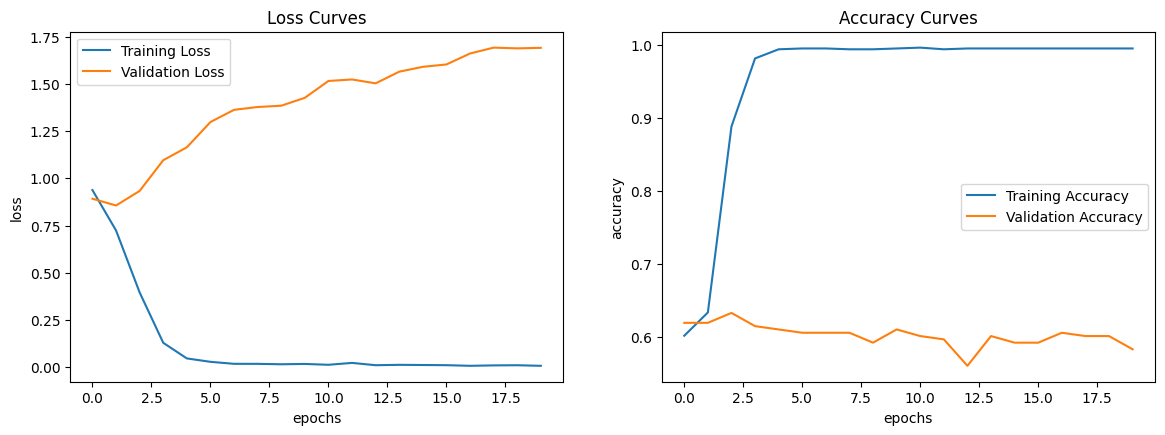

In [55]:
tr_loss = history.history[ 'loss']
val_loss = history.history['val_loss']
tr_acc = history.history[ 'accuracy']
val_acc = history.history[ 'val_accuracy']
epochs = range(len(tr_loss)) # get the epochs as a list to plot along the x-axis

plt.figure(figsize=(14,10))
# Loss curves
ax = plt.subplot(2,2,1)
plt.plot(epochs, tr_loss, label='Training Loss') 
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss Curves')
plt.legend()
# Accuracy curves
ax = plt.subplot(2,2,2)
plt.plot(epochs, tr_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Curves')
plt.legend()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
              precision    recall  f1-score   support

    positive       0.71      0.74      0.72       137
    negative       0.40      0.41      0.41        46
     neutral       0.28      0.24      0.26        38

    accuracy                           0.58       221
   macro avg       0.47      0.46      0.46       221
weighted avg       0.57      0.58      0.58       221



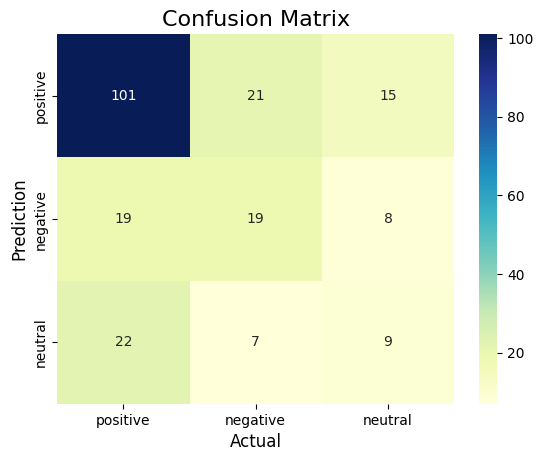

In [56]:
labels = clean_data["Sentiment Polarity"].unique().tolist()

y_pred = model.predict(X_val)

y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(y_val, axis=1)

print(classification_report(Y_test, y_pred, target_names=labels))

cm = confusion_matrix(Y_test, y_pred)
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

In [57]:
from keras.layers import Bidirectional, LSTM, Embedding
from keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context


X = np.asarray(processed_data['padded'].to_list())
y = pd.get_dummies(processed_data['Sentiment Polarity']).values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

maximum_length = 100
max_features = tokenizer_features
embedding_dim = 256

inputs = Input(shape=(maximum_length,), dtype='int32')
x = Embedding(input_dim=max_features, output_dim=embedding_dim)(inputs)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(60, return_sequences=True))(x)
x = Attention()(x)
outputs = Dense(y.shape[1], activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

batch_size = 32
epochs = 20
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_30 (Embedding)        │ (None, 100, 256)       │     7,813,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 100, 120)       │       152,160 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_19 (Attention)        │ (None, 120)            │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,966,375 (30.39 MB)

 Trainable params: 7,966,375 (30.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.5309 - loss: 1.0065 - val_accuracy: 0.6199 - val_loss: 0.9688
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.6287 - loss: 0.9336 - val_accuracy: 0.6199 - val_loss: 0.9599
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.6095 - loss: 0.9550 - val_accuracy: 0.6199 - val_loss: 0.9309
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.6282 - loss: 0.9272 - val_accuracy: 0.6199 - val_loss: 0.9223
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.6169 - loss: 0.9115 - val_accuracy: 0.6199 - val_loss: 0.8958
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.6367 - loss: 0.7908 - val_accuracy: 0.6244 - val_loss: 1.0016
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.7413 - loss: 0.5570 - val_accuracy: 0.6154 - val_loss: 1.1561
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.8675 - loss: 0.3626 - val_accuracy: 0.5656

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
              precision    recall  f1-score   support

    positive       0.70      0.67      0.69       137
    negative       0.35      0.41      0.38        46
     neutral       0.28      0.26      0.27        38

    accuracy                           0.55       221
   macro avg       0.44      0.45      0.45       221
weighted avg       0.56      0.55      0.55       221



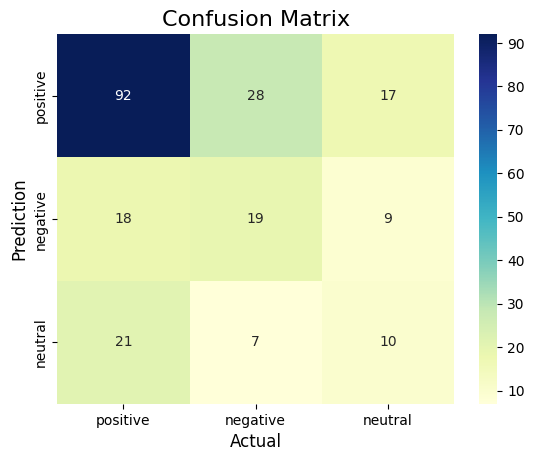

In [58]:
labels = processed_data["Sentiment Polarity"].unique().tolist()

y_pred = model.predict(X_val)

y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(y_val, axis=1)

print(classification_report(Y_test, y_pred, target_names=labels))

cm = confusion_matrix(Y_test, y_pred)
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

Casting to class labels: 100%|██████████| 1114/1114 [00:00<00:00, 179131.06 examples/s]


Map: 100%|██████████| 1114/1114 [00:00<00:00, 12191.50 examples/s]


[1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 2, 2, 1, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 2, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 1, 0, 0, 2, 1, 1, 2, 1, 0, 2, 2, 2, 2, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 2, 2, 0, 1, 0, 0, 1, 0, 2, 0, 1, 2, 0, 2, 0, 1, 0, 1, 2, 0, 1, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 1, 1, 1, 0, 0, 0, 2, 2, 0, 0, 0, 2, 1, 0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 0, 2, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 

100%|██████████| 28/28 [00:06<00:00,  4.43it/s]


Evaluation results: {'eval_loss': 1.2726246118545532, 'eval_model_preparation_time': 0.0033, 'eval_accuracy': 0.4663677130044843, 'eval_runtime': 6.478, 'eval_samples_per_second': 34.424, 'eval_steps_per_second': 4.322}


100%|██████████| 28/28 [00:06<00:00,  4.46it/s]

[1 1 2 1 1 1 0 2 0 0 1 2 0 1 2 1 1 0 1 1 2 0 2 1 1 0 1 1 2 0 1 1 1 1 2 2 0
 1 2 0 1 0 1 0 2 0 1 2 1 1 1 0 0 0 0 2 1 1 1 0 0 2 1 0 2 2 1 0 1 0 0 2 1 0
 0 1 1 1 0 1 1 1 1 1 0 0 1 0 1 2 0 1 2 0 2 2 0 1 1 1 1 1 2 0 0 1 0 1 0 0 2
 1 0 0 1 1 2 1 1 1 2 0 2 0 2 0 1 1 1 2 1 0 2 2 1 0 1 2 1 0 1 1 0 1 2 2 1 0
 0 2 1 1 0 0 2 2 0 1 1 1 1 1 1 1 1 1 1 2 1 2 1 0 0 0 1 0 1 1 0 1 0 2 1 0 2
 2 0 0 2 2 1 0 1 1 2 1 2 0 1 1 1 1 2 0 0 0 1 2 1 1 1 0 2 1 0 1 1 0 2 0 1 1
 1]
[1, 0, 2, 0, 0, 1, 0, 2, 0, 0, 1, 0, 2, 0, 1, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 2, 0, 1, 2, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 2,

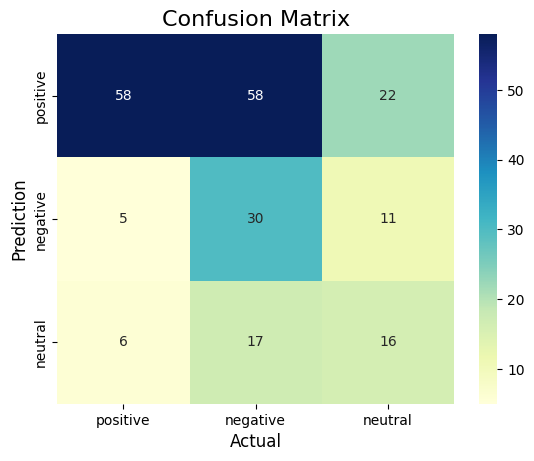

In [60]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

bert_data = clean_data.copy(deep=True)
bert_data = bert_data.rename(columns={'Sentiment Polarity':'label'})

dataset = Dataset.from_pandas(bert_data[['Text', 'label']])
dataset = dataset.class_encode_column('label')

model_name = 'Souvikcmsa/BERT_sentiment_analysis'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['Text'], padding='max_length', truncation=True, max_length=100)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

train_test_split = tokenized_datasets.train_test_split(test_size=0.2, seed=42, stratify_by_column='label')
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

print(train_dataset['label'])
print(test_dataset['label'])

model = AutoModelForSequenceClassification.from_pretrained(model_name)#, num_labels=len(model_labels))

# Define the compute_metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {'accuracy': (preds == p.label_ids).mean()}

# Initialize the Trainer
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Evaluate the model
eval_result = trainer.evaluate()
print(f"Evaluation results: {eval_result}")

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
actual = test_dataset['label']

print(preds)
print(actual)

labels = clean_data['Sentiment Polarity'].unique()

report = classification_report(actual, preds, target_names=labels)  # Replace with your actual class names
print(report)

cm = confusion_matrix(actual, preds)
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()